In [2]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df["Heart Disease"] = train_df["Heart Disease"].map({"Absence": 0,"Presence": 1})
TARGET = 'Heart Disease'
base_features = [col for col in test_df.columns if col not in [TARGET, 'id']]
num_features = ['Age', 'BP', 'Cholesterol','Max HR','ST depression']
cat_features = [col for col in base_features if col not in num_features]
train_df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


In [4]:
summary = pd.DataFrame({
    'Unique_Count': test_df[base_features].nunique(),
    'Dtype': test_df[base_features].dtypes,
    'Null_Count': test_df[base_features].isnull().sum(),
})
display(summary.sort_values('Unique_Count'))

,Unique_Count,Dtype,Null_Count
Sex,2,int64,0
FBS over 120,2,int64,0
Exercise angina,2,int64,0
EKG results,3,int64,0
Slope of ST,3,int64,0
Thallium,3,int64,0
Number of vessels fluro,4,int64,0
Chest pain type,4,int64,0
Age,43,int64,0
ST depression,64,float64,0


In [5]:
for df in [train_df, test_df]:
    for col in cat_features:
        df[col] = df[col].astype(str)

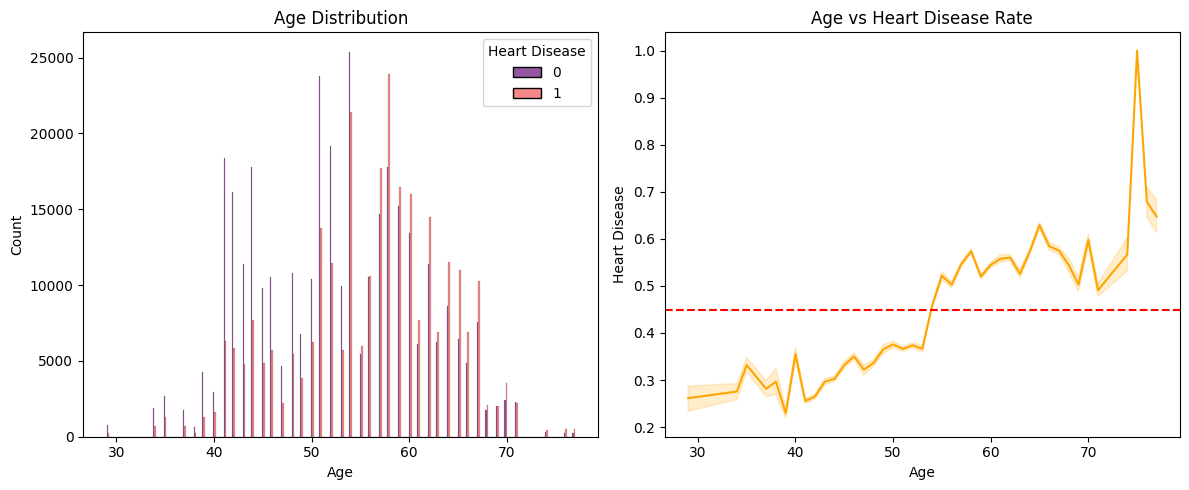

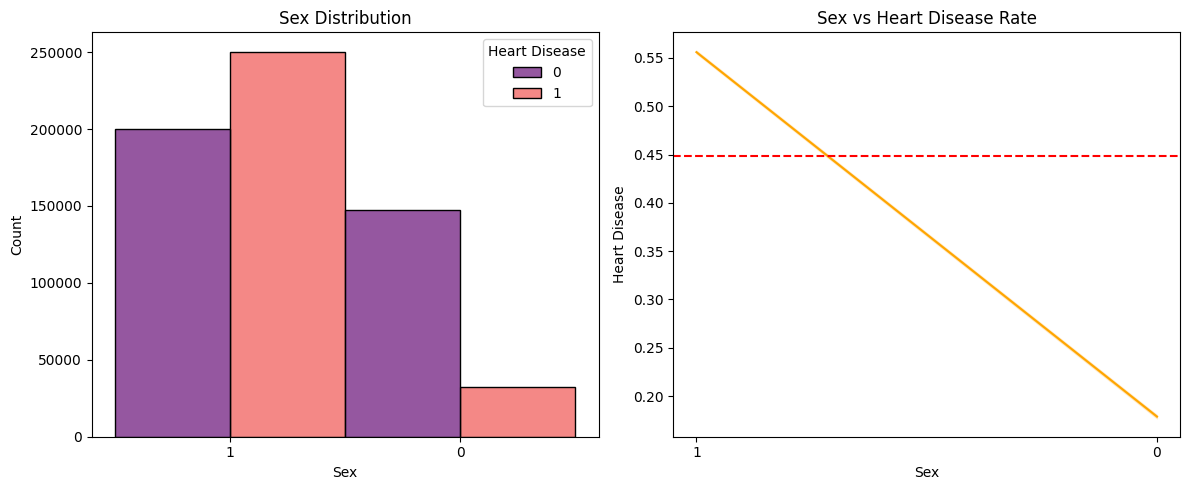

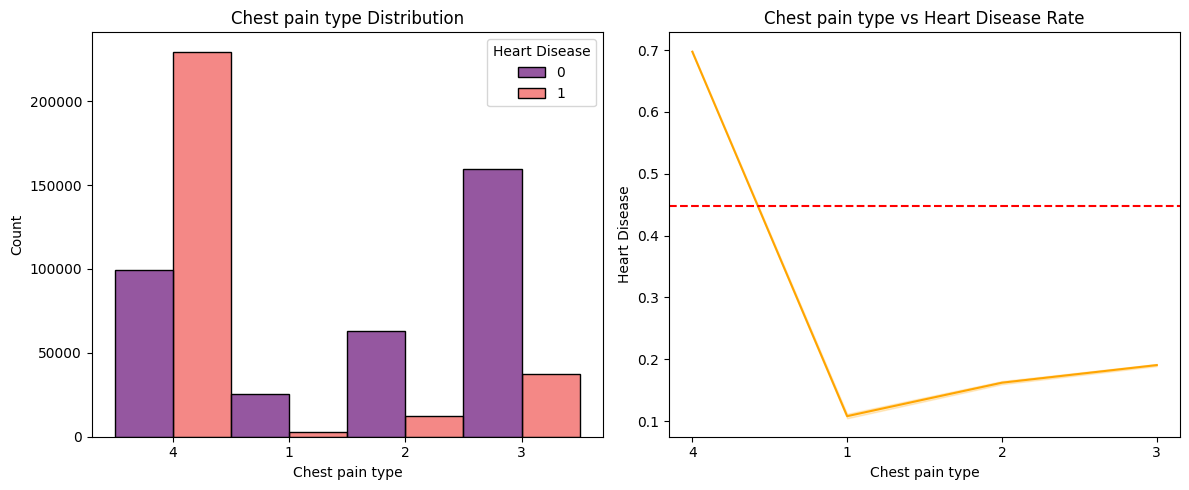

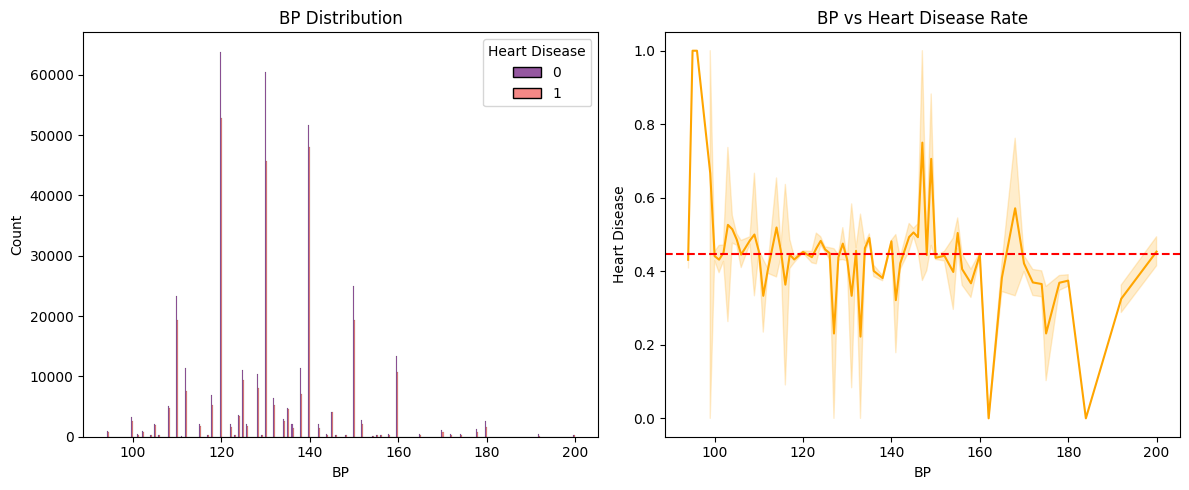

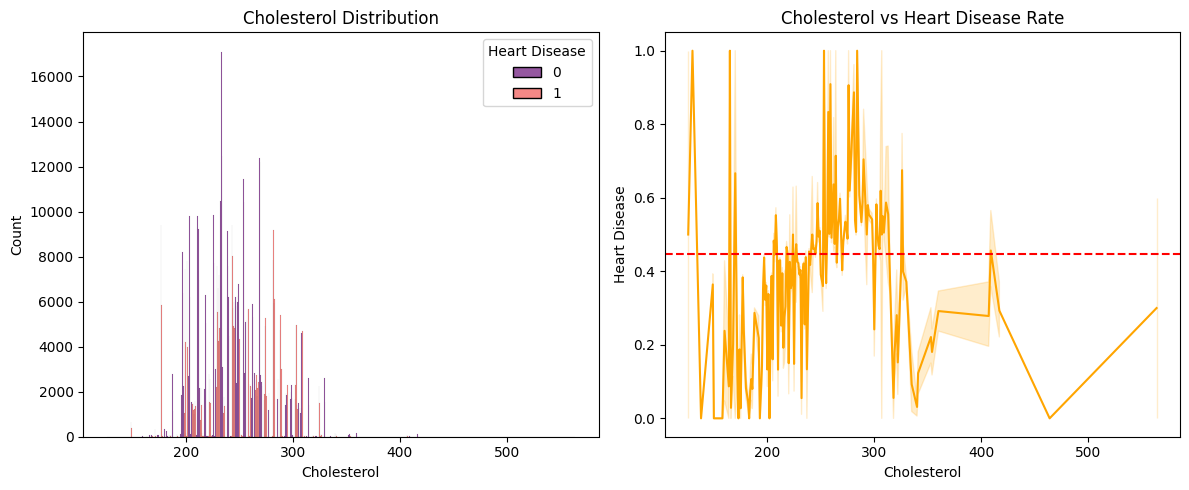

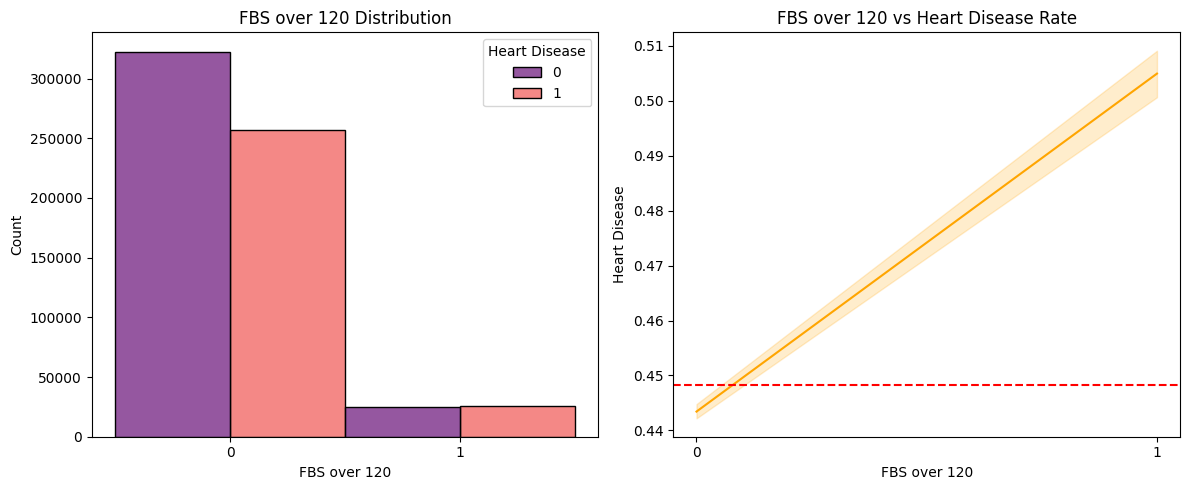

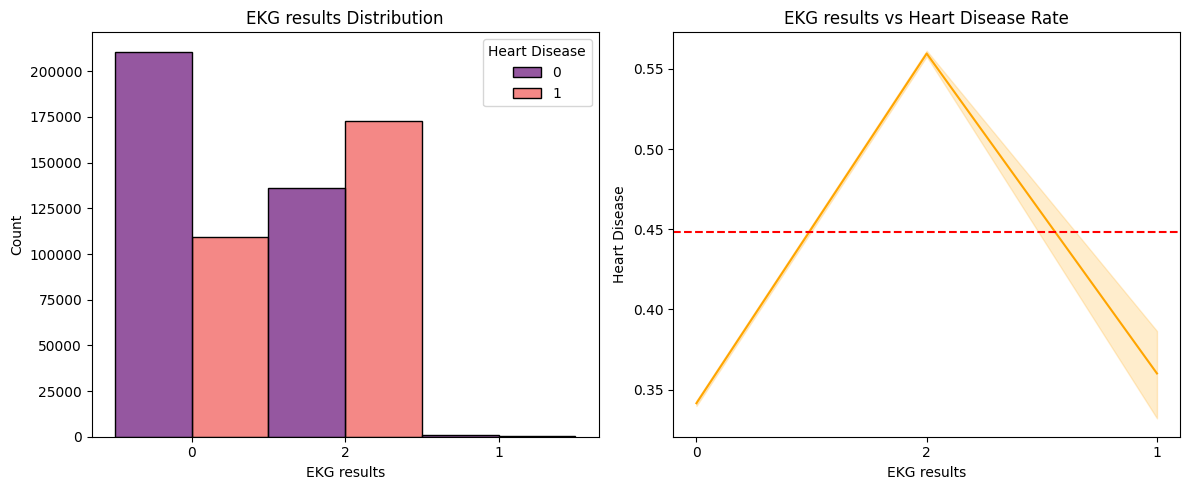

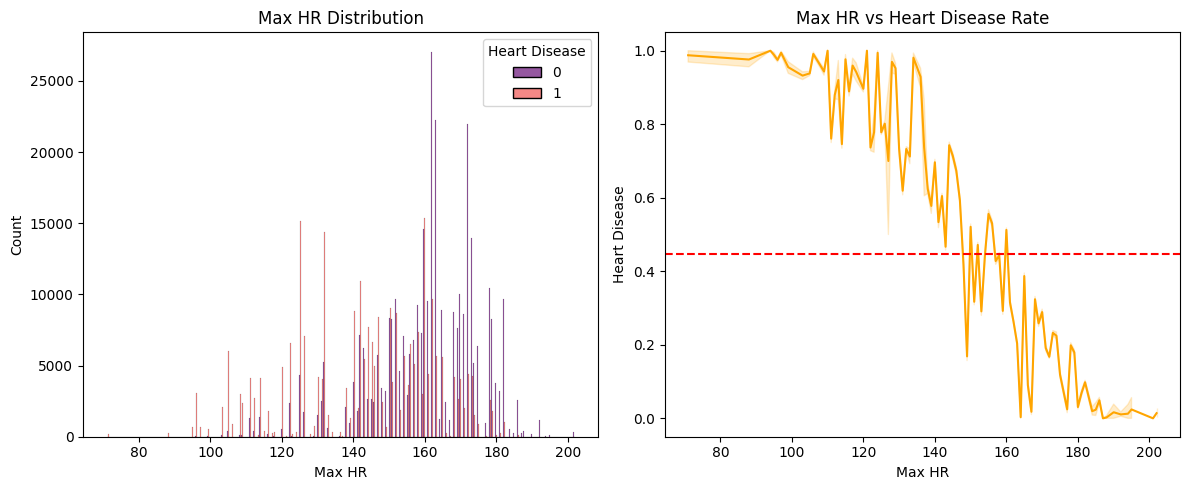

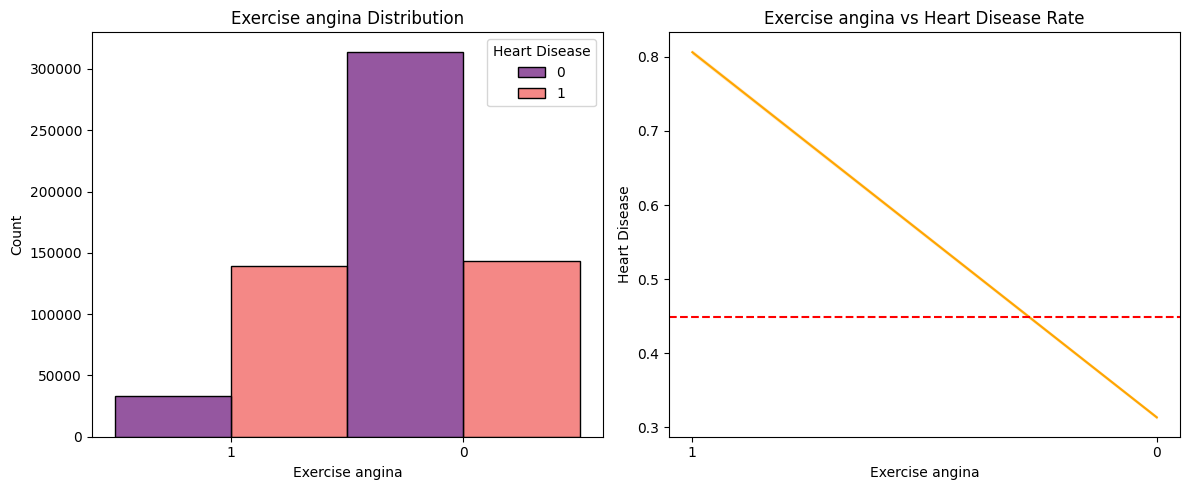

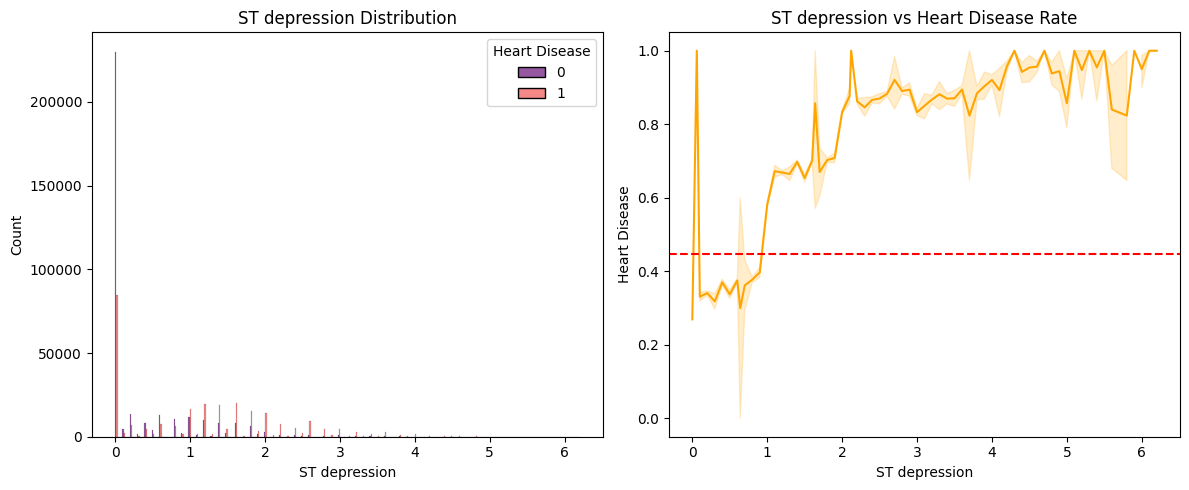

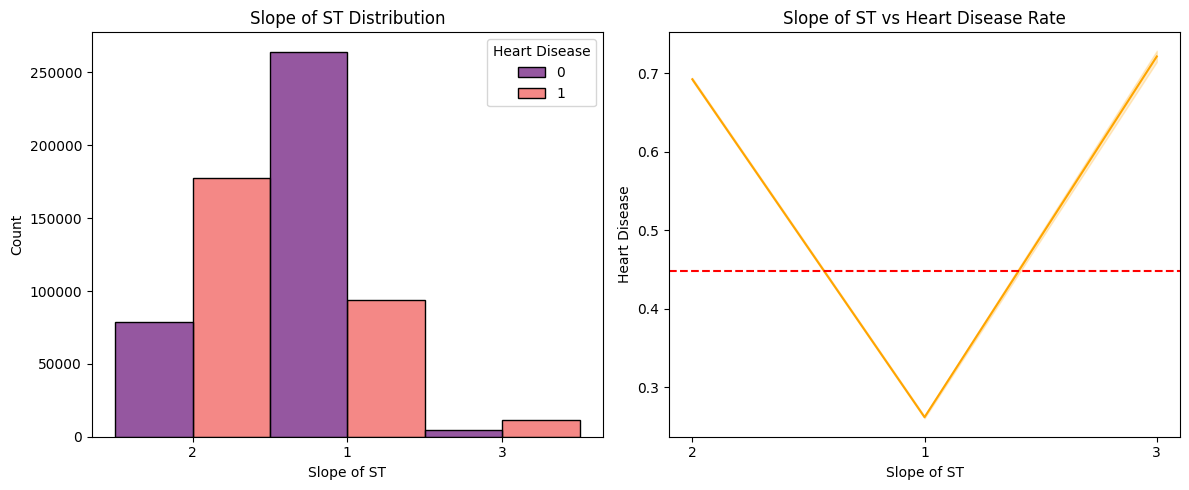

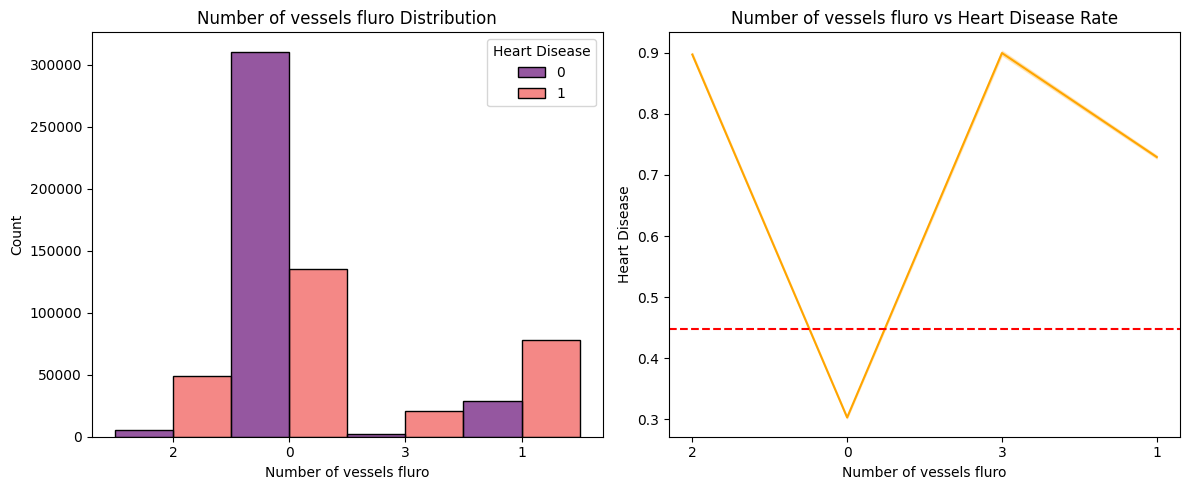

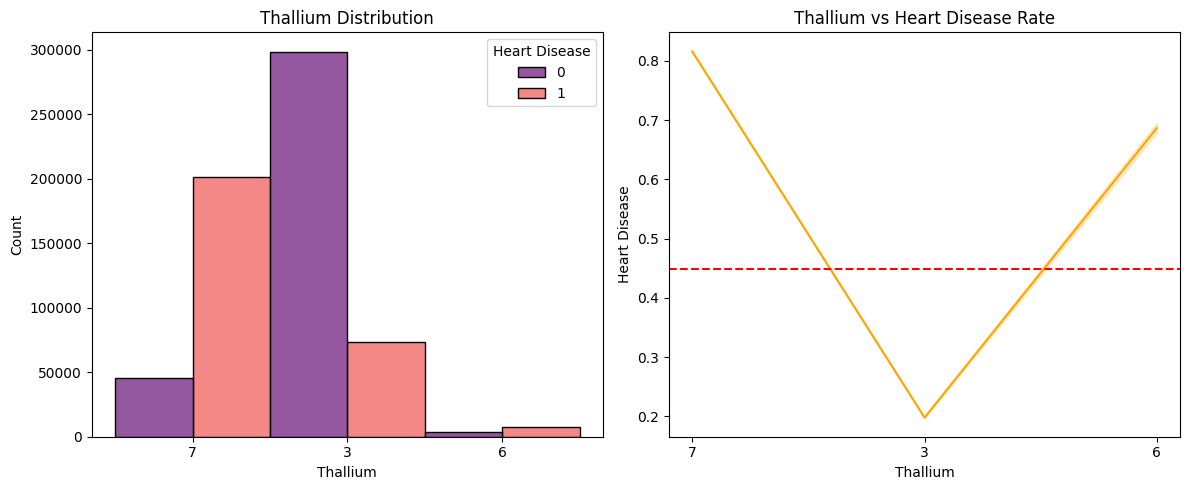

In [6]:
for col in base_features:
    plt.figure(figsize=(12, 5))
    

    plt.subplot(1, 2, 1)
    sns.histplot(data=train_df, x=col, hue='Heart Disease', multiple="dodge", palette='magma')
    plt.title(f'{col} Distribution')


    plt.subplot(1, 2, 2)
    sns.lineplot(data=train_df, x=col, y='Heart Disease', color='orange')
    plt.axhline(train_df['Heart Disease'].mean(), linestyle='--', color='red', label='Global Mean')
    plt.title(f'{col} vs Heart Disease Rate')
    
    plt.tight_layout()
    plt.show()

In [7]:
for df in [train_df,test_df]:
    for col in num_features:
        if col in df.columns:
            df[f'log_{col}'] = np.log1p(df[col])
            df[f'{col}_sq'] = df[col] ** 2

In [8]:
for df in [train_df, test_df]:
    for col in base_features:
        df[col] = df[col].astype(str)

In [9]:
for col in base_features:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype('category')
    if col in test_df.columns:
        test_df[col] = test_df[col].astype('category')

X_train = train_df.drop(columns=["id","Heart Disease"])
Y_train = pd.DataFrame(train_df["Heart Disease"], columns=["Heart Disease"])
id_train=train_df["id"]
X_test=test_df.drop(columns=["id"])
id_test=test_df["id"]
X_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Age                      630000 non-null  category
 1   Sex                      630000 non-null  category
 2   Chest pain type          630000 non-null  category
 3   BP                       630000 non-null  category
 4   Cholesterol              630000 non-null  category
 5   FBS over 120             630000 non-null  category
 6   EKG results              630000 non-null  category
 7   Max HR                   630000 non-null  category
 8   Exercise angina          630000 non-null  category
 9   ST depression            630000 non-null  category
 10  Slope of ST              630000 non-null  category
 11  Number of vessels fluro  630000 non-null  category
 12  Thallium                 630000 non-null  category
 13  log_Age                  630000 non-null  float64 
 14 

In [10]:
# def objective(trial, X_train, Y_train):

#     params = {
#         "max_depth": trial.suggest_int("max_depth", 3, 7),
#         "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
#         "gamma": trial.suggest_float("gamma", 1e-4, 1.0, log=True),
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         "colsample_bynode": trial.suggest_float("colsample_bynode", 0.6, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
#         "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05),
#     }

#     model = XGBClassifier(
#         **params,
#         n_estimators=7000,
#         eval_metric="auc",
#         tree_method="hist",
#         early_stopping_rounds=100,
#         random_state=0,
#         n_jobs=-1,
#         enable_categorical=True
#     )

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

#     auc_scores = []

#     for tr_idx, va_idx in skf.split(X_train, Y_train):
#         x_tr, y_tr = X_train.iloc[tr_idx], Y_train.iloc[tr_idx]
#         x_va, y_va = X_train.iloc[va_idx], Y_train.iloc[va_idx]
#         te_cols=base_features
#         for col in te_cols:
#             target_means = y_tr.iloc[:, 0].groupby(x_tr[col], observed=False).mean()
            
#             x_tr[f'{col}_TE'] = x_tr[col].map(target_means).astype(float)
#             x_va[f'{col}_TE'] = x_va[col].map(target_means).astype(float)

#         model.fit(x_tr, y_tr, eval_set=[(x_va, y_va)], verbose=False)
#         y_pred = model.predict_proba(x_va)[:, 1]

#         auc_scores.append(roc_auc_score(y_va, y_pred))

#     return np.mean(auc_scores)

# study = optuna.create_study(
#     study_name="my_xgb_study",
#     direction="maximize",
#     load_if_exists=True
# )

# for batch in range(20):
#     print(f"Batch {batch+1} 開始")
#     study.optimize(lambda trial: objective(trial, X_train, Y_train), n_trials=10)
#     print("現在のベスト値:", study.best_value)
#     print("ベストパラメータ:", study.best_params)

In [11]:
xgb_params = {
    'n_estimators': 10000,
    'learning_rate': 0.02,
    'max_depth': 3,
    'subsample': 0.8,
    'num_parallel_tree': 2,
    'reg_lambda': 3,
    'colsample_bytree': 0.6, 
    'colsample_bynode': 0.7,
    'tree_method': 'hist',
    'random_state': 42,
    'early_stopping_rounds': 100,
    'enable_categorical': True,
    'eval_metric': 'auc'}
opu_params=  {'max_depth': 3, 'min_child_weight': 0.9843612818047274, 'gamma': 0.003094718232183869, 'subsample': 0.6766224814487808,
              'colsample_bytree': 0.6728305598037141, 'colsample_bynode': 0.6135164007610299, 'colsample_bylevel': 0.620128359126452,
              'reg_alpha': 2.1814099300555845e-08, 'reg_lambda': 0.0002689724836958362, 'learning_rate': 0.010234795162589435}
def train(input_x,input_y,input_id,list_nfold=[0,1,2,3,4],n_splits=5):
    all_train_oof=list()
    all_metrics=list()
    all_imp=list()
    all_test_oof=list()
    print(input_x.shape)
    
    train_oof=np.zeros(len(input_x))
    test_oof =np.zeros((len(X_test),len(list_nfold)))
    metrics = []
    imp = pd.DataFrame()
    cv = list(StratifiedKFold(
                n_splits=n_splits,
                shuffle=True,
                random_state=123).split(input_x, input_y))
    for nfold in list_nfold:
        model=XGBClassifier(**opu_params,
                    n_estimators=7000,
                    eval_metric="auc",
                    tree_method="hist",
                    early_stopping_rounds=100,
                    random_state=0,
                    n_jobs=-1,
                    enable_categorical=True)
        # model=XGBClassifier(learning_rate=0.020264093891987044,
        #                     max_depth=4,
        #                     min_child_weight=9.683524038831745,
        #                     subsample=0.756120175176546,
        #                     colsample_bytree=0.45328507892945213,
        #                     gamma=0.7590460405945648,
        #                     reg_alpha=2.6444040418960233,
        #                     reg_lambda=0.49932858064771823,
        #                     n_estimators=7000,
        #                     enable_categorical=True,
        #                     eval_metric="auc",
        #                     tree_method="hist",
        #                     random_state=42,)
        print(nfold)
        idx_tr,idx_va = cv[nfold][0],cv[nfold][1]
        x_tr, y_tr, id_tr = input_x.loc[idx_tr], input_y.loc[idx_tr], input_id.loc[idx_tr]
        
        x_va, y_va, id_va = input_x.loc[idx_va], input_y.loc[idx_va], input_id.loc[idx_va]
        model.fit( x_tr, y_tr,
                    eval_set=[(x_va, y_va)],
                    verbose=False)

        y_va_pred = model.predict_proba(x_va)[:,1]
        va_metric = roc_auc_score(y_va, y_va_pred)
        metrics.append(va_metric)
        print(va_metric)
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        tr_metric = roc_auc_score(y_tr, y_tr_pred)
        print(tr_metric)
        test_oof[:,nfold] = model.predict_proba(X_test)[:,1]

        train_oof[idx_va] = y_va_pred
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        else:
            importances = model.get_feature_importance()
    
        imp_fold=pd.DataFrame({ "col":x_tr.columns,"imp": importances,"nfold":nfold})
        imp=pd.concat([imp,imp_fold])
        print("result")
            
    
    print(metrics)
    
    train_oof = pd.concat([input_id,pd.DataFrame({"pred":train_oof})],axis=1)
    
    imp = imp.groupby("col")["imp"].agg(["mean","std"]).reset_index(drop=False)
    imp.columns = ["col","imp","imp_std"]
    all_train_oof.append(train_oof)
    all_metrics.append(metrics)
    all_imp.append(imp)
    all_test_oof.append(test_oof)

   
    return all_train_oof,all_imp,all_metrics,all_test_oof

In [12]:
train_oof,imp,metrics,test_oof = train(X_train,Y_train,id_train,
                                      list_nfold=[0,1,2,3,4],n_splits=5)

(630000, 23)
0
0.9554633022471231
0.9566629474626359
result
1
0.9568455727857661
0.9561475508269209
result
2
0.9554030434949349
0.9566165102943562
result
3
0.9544568082402918
0.956939735955346
result
4
0.9561778755310643
0.9564427589990875
result
[0.9554633022471231, 0.9568455727857661, 0.9554030434949349, 0.9544568082402918, 0.9561778755310643]


In [13]:
scores = np.array(metrics)
average = np.mean(scores)
average

np.float64(0.9556693204598359)

C:\Users\Owner\AppData\Local\Temp\ipykernel_20092\3564431312.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='imp', y='col', palette='viridis')


<Axes: xlabel='imp', ylabel='col'>

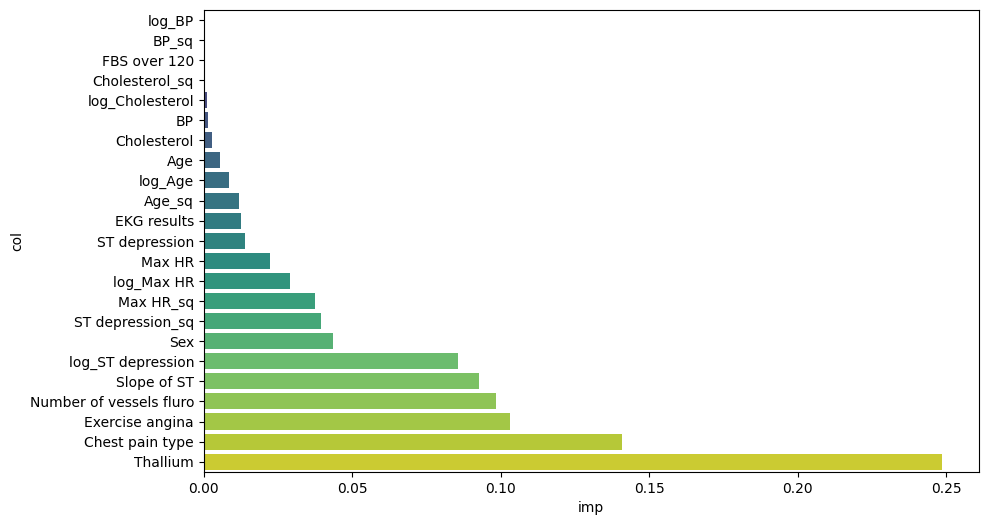

In [14]:
imp_df = pd.DataFrame(imp[0])
imp_df = imp_df.sort_values("imp", ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(data=imp_df, x='imp', y='col', palette='viridis')

In [15]:
xgb = pd.DataFrame({
    "id": id_test,
    "Heart Disease": test_oof[0].mean(axis=1)
})
xgb.to_csv("xgb.csv",index=False)